In [1]:
import pandas as pd

csv_df = pd.read_csv('CornPoints2022-ottawa-montreal.csv')
csv_df.head()

,system:index,landcover,longitude,latitude
0,1,1,-73.094563,45.934212
1,8,1,-75.275531,45.120618
2,9,1,-74.918176,45.421723
3,14,1,-73.061050,45.305319
4,18,1,-73.240261,45.080768


In [76]:
import requests

sample = csv_df.sample(5)

i = 0
data = []
for entry in sample.itertuples():
    i += 1
    if i > 5:
        break

    payload = {
        "latitude": entry.latitude,
        "longitude": entry.longitude,
        "year": 2022
    }
    print("Requesting:", payload)
    r = requests.post("http://127.0.0.1:5000/getData", json=payload, timeout=10)
    r.raise_for_status()
    data.append(r.json())

with open('data.json', 'w') as f:
    import json
    json.dump(data, f, indent=2)

Requesting: {'latitude': 45.69681793317195, 'longitude': -73.99378898441887, 'year': 2022}
Requesting: {'latitude': 45.48152461570274, 'longitude': -74.35628020862808, 'year': 2022}
Requesting: {'latitude': 45.32043033334216, 'longitude': -74.28612543086079, 'year': 2022}
Requesting: {'latitude': 45.16461358804231, 'longitude': -74.22993375588014, 'year': 2022}
Requesting: {'latitude': 45.77668879117208, 'longitude': -75.03860001414272, 'year': 2022}


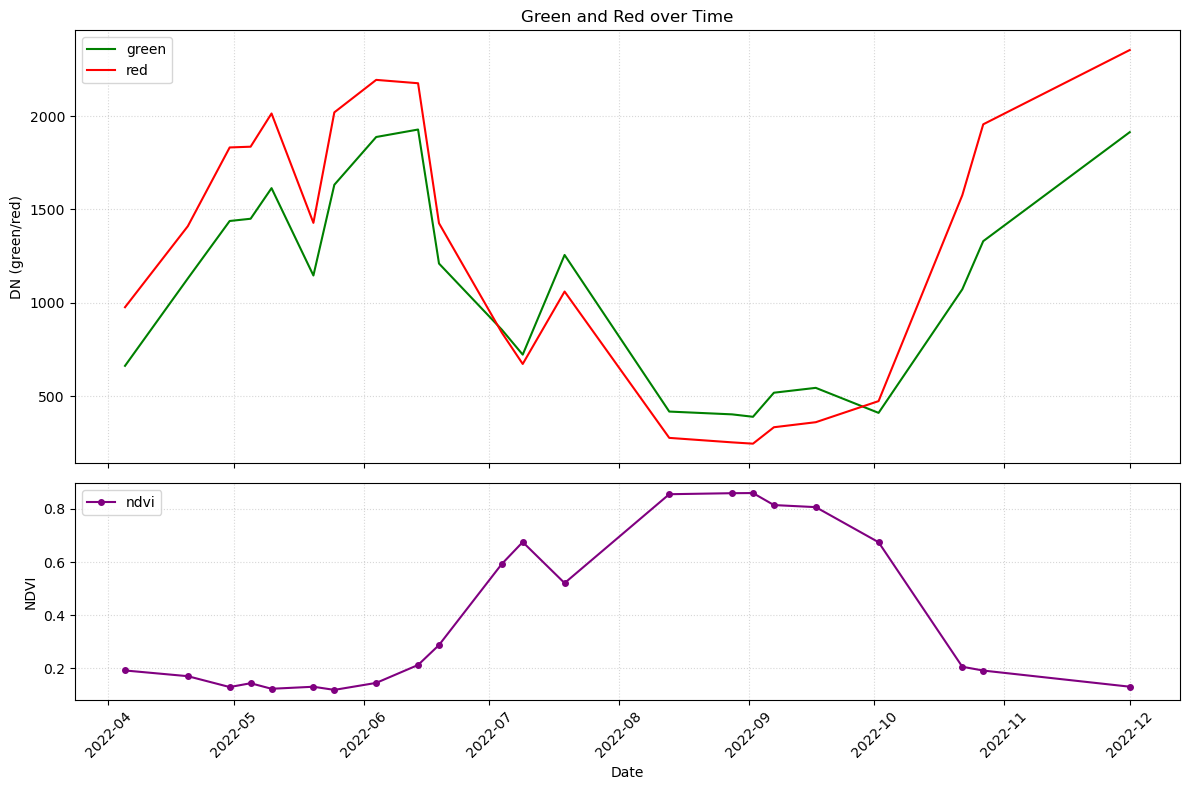

            green   red      ndvi  ndvi_smooth
date                                          
2022-04-05    662   976  0.192053     0.194483
2022-04-20   1130  1410  0.170588     0.161533
2022-04-30   1438  1832  0.129691     0.142763
2022-05-05   1450  1836  0.144056     0.133709
2022-05-10   1614  2014  0.123204     0.125065


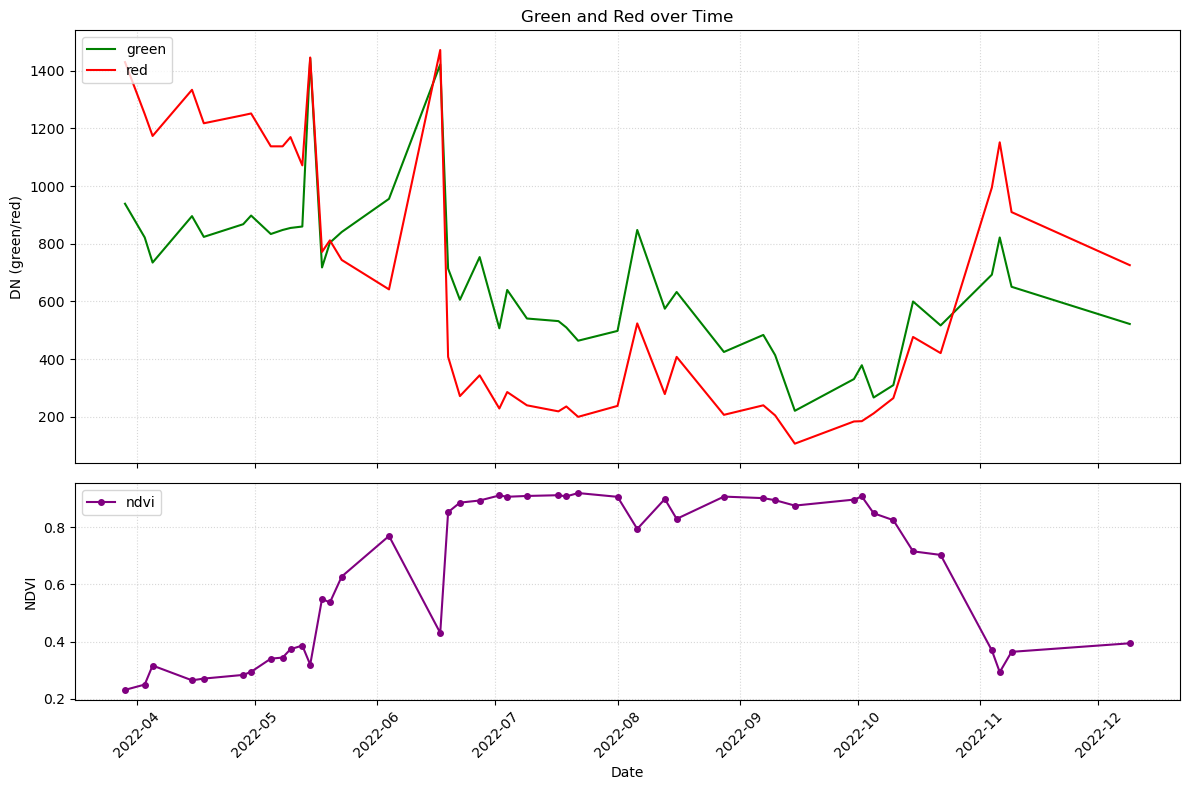

            green   red      ndvi  ndvi_smooth
date                                          
2022-03-29    939  1430  0.231183     0.226344
2022-04-03    822  1250  0.249700     0.270269
2022-04-05    735  1174  0.316249     0.284669
2022-04-15    896  1334  0.264609     0.282020
2022-04-18    824  1218  0.270659     0.277846


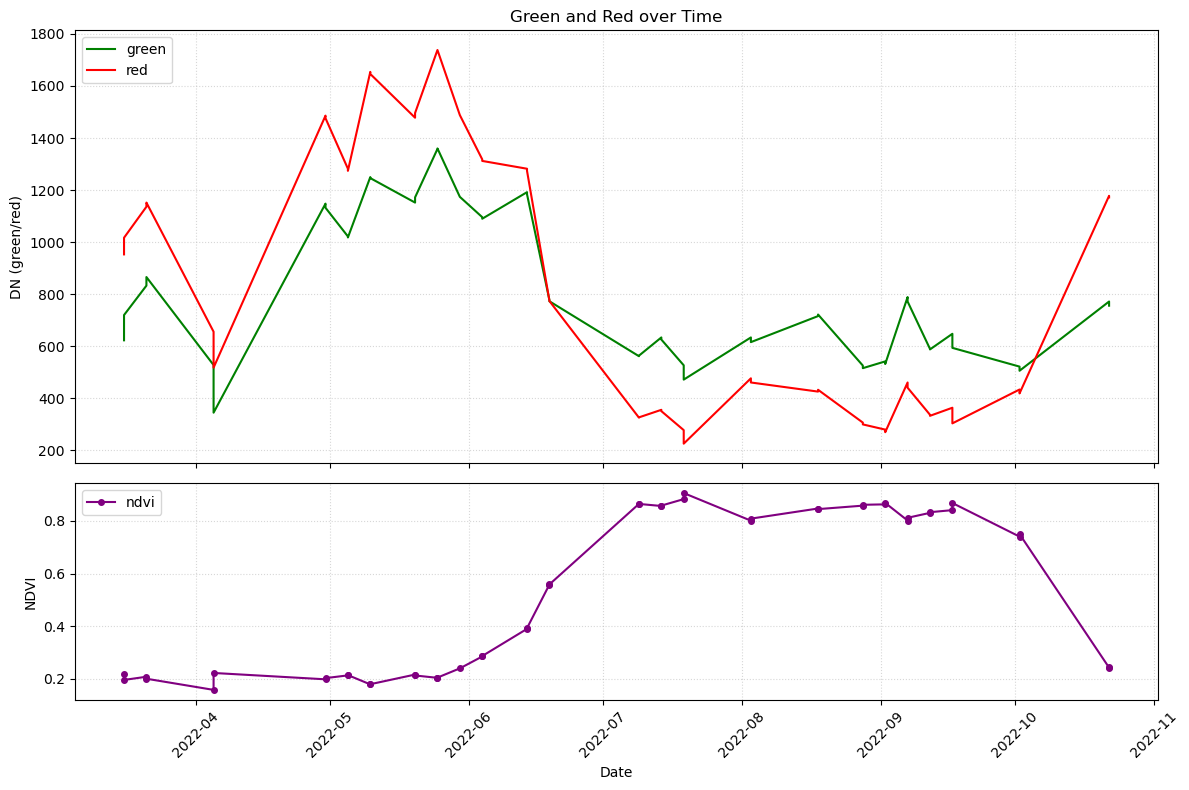

            green   red      ndvi  ndvi_smooth
date                                          
2022-03-16    623   953  0.218532     0.216831
2022-03-16    720  1017  0.195730     0.204734
2022-03-21    833  1136  0.207810     0.196053
2022-03-21    866  1152  0.200278     0.191279
2022-04-05    528   656  0.157895     0.193391


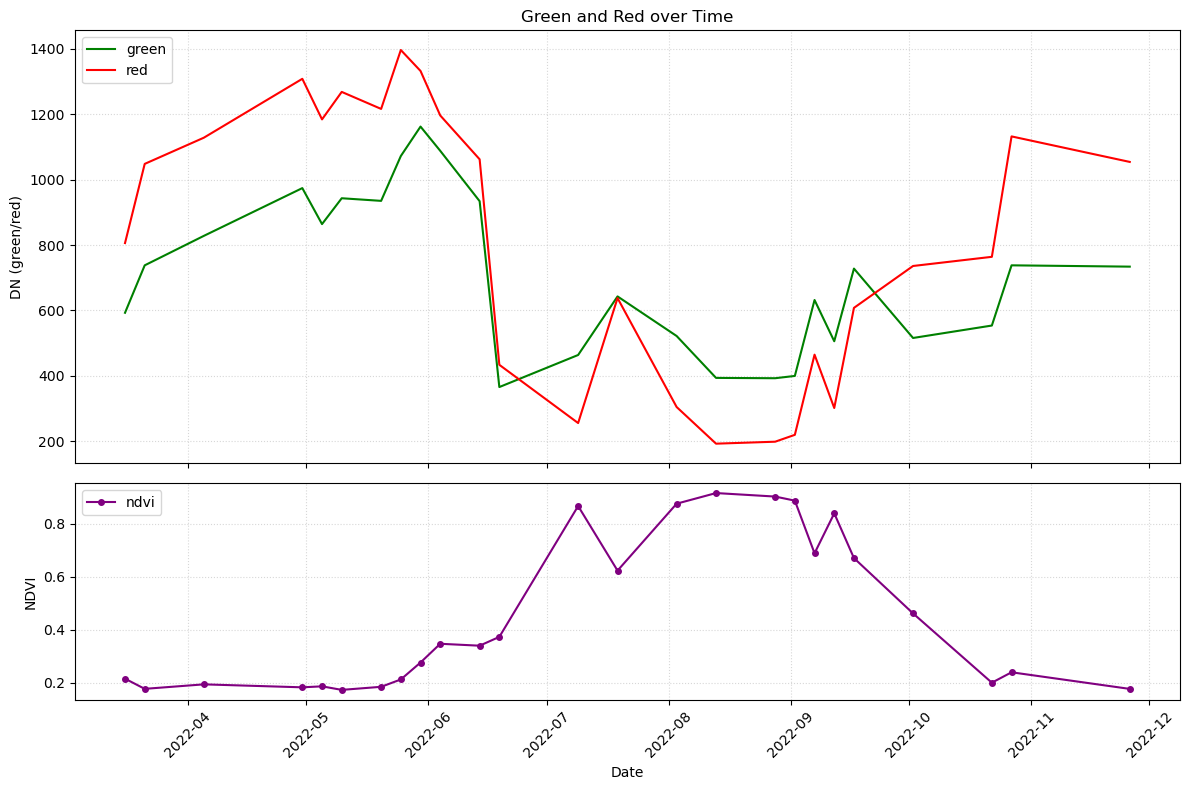

            green   red      ndvi  ndvi_smooth
date                                          
2022-03-16    593   806  0.215190     0.209771
2022-03-21    738  1048  0.176748     0.191828
2022-04-05    828  1128  0.193710     0.183409
2022-04-30    974  1308  0.182500     0.181279
2022-05-05    864  1184  0.186254     0.180597


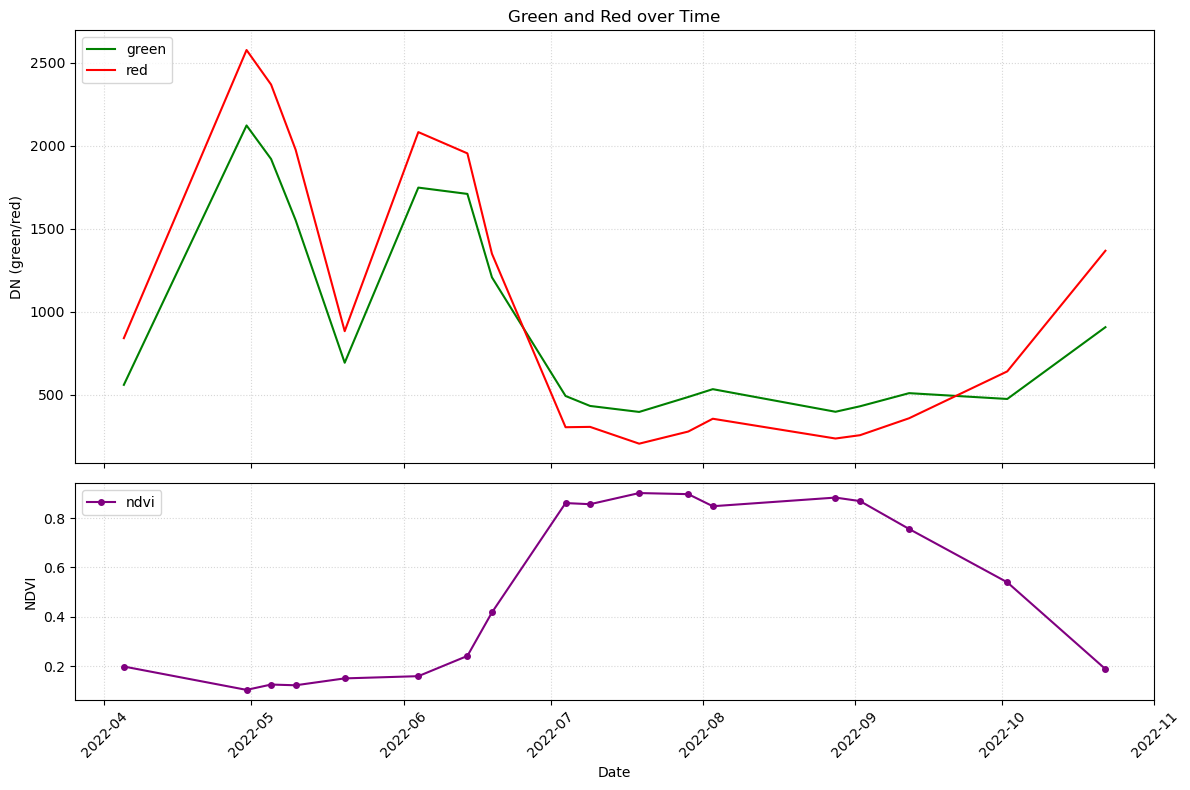

            green   red      ndvi  ndvi_smooth
date                                          
2022-04-05    561   842  0.198858     0.188124
2022-04-30   2122  2576  0.104312     0.132610
2022-05-05   1920  2368  0.125877     0.110589
2022-05-10   1552  1976  0.122947     0.115806
2022-05-20    694   884  0.150817     0.133860


In [62]:
# Load data.json and plot green+red on top, ndvi on bottom (shared x-axis)
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Read the JSON file
with open('data.json', 'r') as f:
    datas = json.load(f)

for data in datas:
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    from scipy.signal import savgol_filter
    df['ndvi_smooth'] = savgol_filter(df['ndvi'], window_length=7, polyorder=3)
    # df['ndvi_smooth'] = df['ndvi'].rolling(window=5, center=True, min_periods=1).mean()

    # ndvi_min = df['ndvi_smooth'].min()
    # ndvi_max = df['ndvi_smooth'].max()
    # df['ndvi_norm'] = (df['ndvi_smooth'] - ndvi_min) / (ndvi_max - ndvi_min)

    # Set date index
    df.set_index('date', inplace=True)

    # Create two stacked subplots that share the x-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12,8), sharex=True,
                                            gridspec_kw={'height_ratios':[2,1]})

    # Top plot: green and red
    ax_top.plot(df.index, df['green'], label='green', color='green')
    ax_top.plot(df.index, df['red'], label='red', color='red')
    ax_top.set_ylabel('DN (green/red)')
    ax_top.legend(loc='upper left')
    ax_top.set_title('Green and Red over Time')
    ax_top.grid(True, linestyle=':', alpha=0.5)

    # Bottom plot: NDVI
    ax_bottom.plot(df.index, df['ndvi'], label='ndvi', color='purple', marker='o', markersize=4)
    # ax_bottom.plot(df.index, df['ndvi_smooth'], color='purple', linewidth=2, label='Smoothed NDVI')
    # ax_bottom.plot(df.index, df['ndvi_norm'], color='blue', linewidth=2, label='Normalized NDVI', alpha=0.5)
    ax_bottom.set_ylabel('NDVI')
    ax_bottom.set_xlabel('Date')
    ax_bottom.legend(loc='upper left')
    ax_bottom.grid(True, linestyle=':', alpha=0.5)

    # Improve x-axis date labels
    plt.setp(ax_bottom.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

    # Display head of dataframe
    print(df.head())


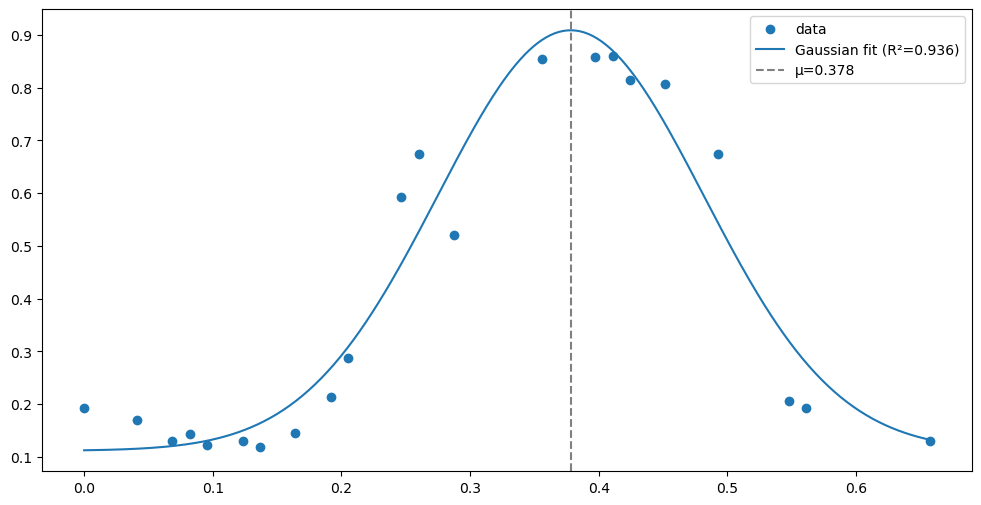

Fitted params: A, mu, sigma, offset = [0.79724782 0.37817647 0.10342613 0.11153448]


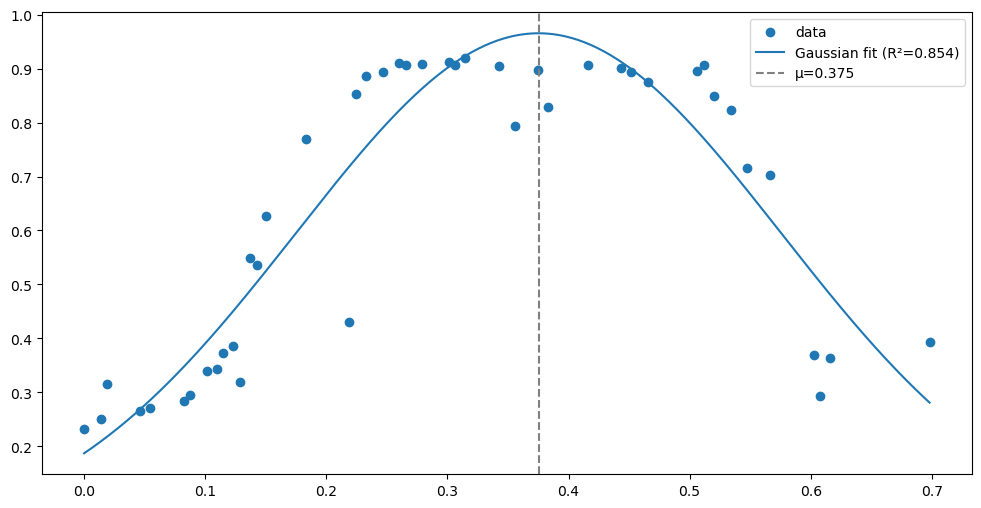

Fitted params: A, mu, sigma, offset = [0.94151951 0.3752406  0.20035185 0.02406928]


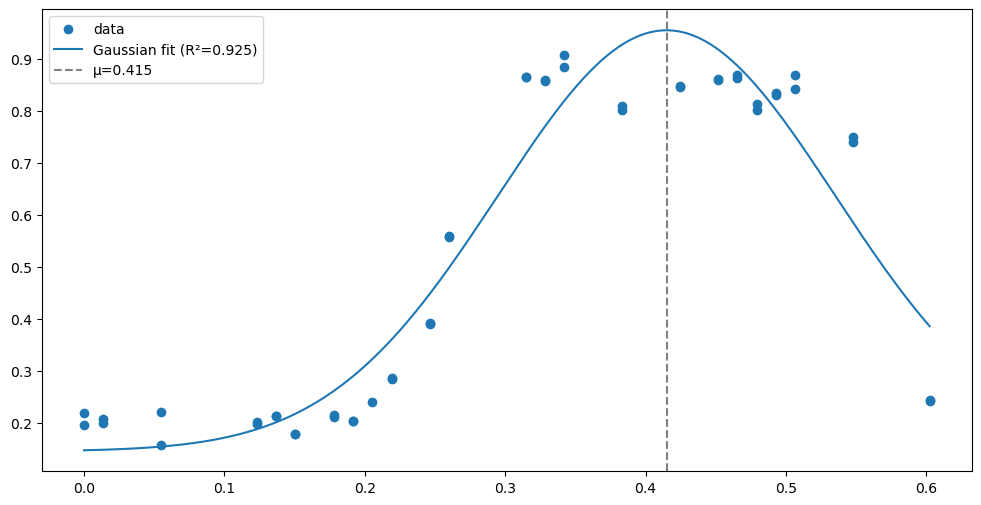

Fitted params: A, mu, sigma, offset = [0.80886005 0.41495175 0.12030736 0.14566298]


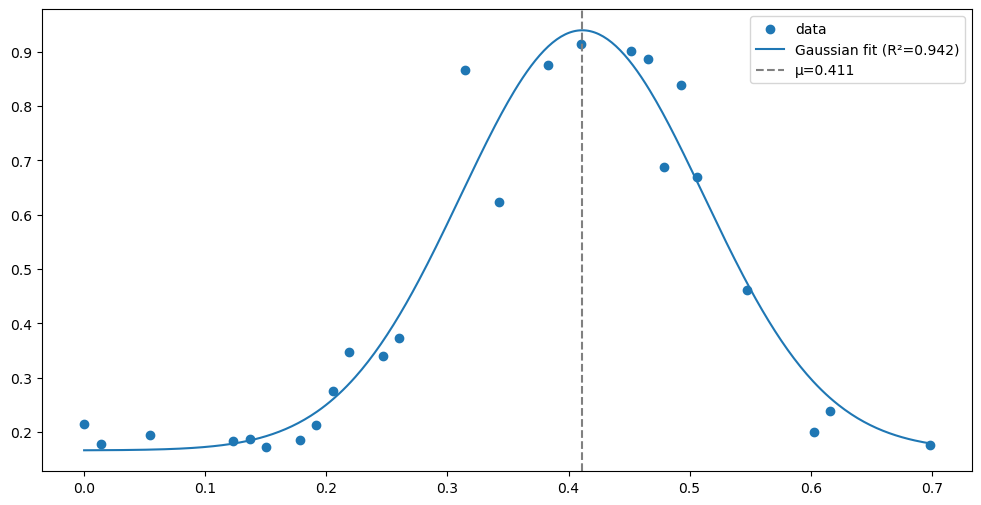

Fitted params: A, mu, sigma, offset = [0.77402547 0.41133736 0.10031586 0.16585631]


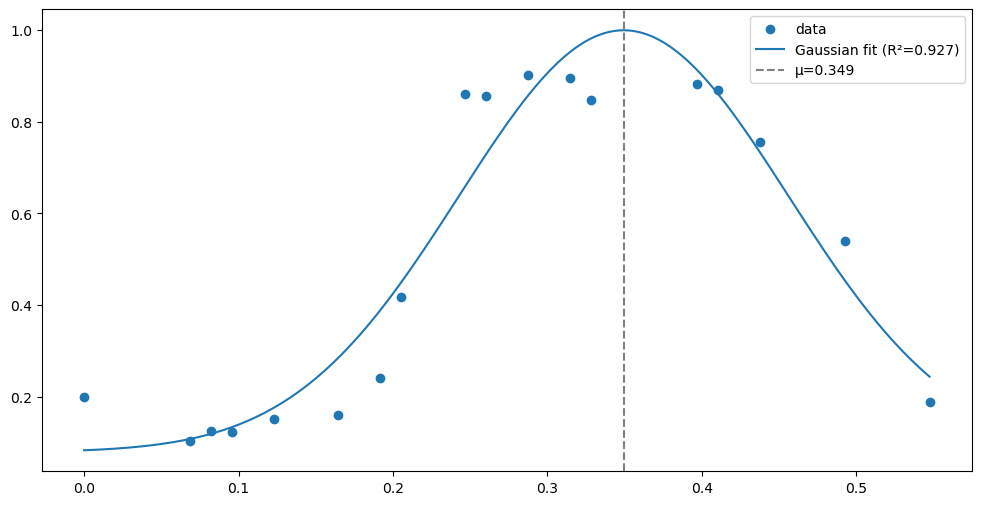

Fitted params: A, mu, sigma, offset = [0.92107031 0.34946599 0.10684119 0.07862087]


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

for data in datas:
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    df.set_index('date', inplace=True)
    
    # Example discrete data (replace x_data,y_data with your own)
    x_data = df.index.map(datetime.toordinal).to_numpy()
    x_data = (x_data - x_data.min()) / 365.25  # normalize
    # synthetic noisy bell
    y_true = 5.0 * np.exp(-0.5 * ((x_data - 5.2) / 0.9)**2)
    rng = np.random.default_rng(0)
    y_data = df['ndvi'].to_numpy()

    # Gaussian model
    def gaussian(x, A, mu, sigma, offset):
        return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + offset

    # initial guesses: amplitude, center, sigma, offset
    A0 = np.max(y_data) - np.min(y_data)
    mu0 = x_data[np.argmax(y_data)]
    # rough FWHM estimate: span where y > half max
    half = np.min(y_data) + 0.5 * (np.max(y_data) - np.min(y_data))
    indices = np.where(y_data > half)[0]
    if len(indices) >= 2:
        fwhm = x_data[indices[-1]] - x_data[indices[0]]
    else:
        fwhm = (x_data[-1] - x_data[0]) / 4.0
    sigma0 = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    p0 = [A0, mu0, max(sigma0, 1e-3), np.min(y_data)]

    # bounds (optional)
    lower = [0.0, x_data.min(), 1e-6, -np.inf]
    upper = [np.inf, x_data.max(), np.inf, np.inf]

    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=p0, bounds=(lower, upper))
    A_fit, mu_fit, sigma_fit, offset_fit = popt

    # goodness-of-fit (R^2)
    residuals = y_data - gaussian(x_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2 = 1 - ss_res/ss_tot

    # plot
    xx = np.linspace(x_data.min(), x_data.max(), 400)
    yy_fit = gaussian(xx, *popt)

    fig, ax = plt.subplots(figsize=(12,6), dpi=100)   # width=8in, height=3in; adjust as needed
    plt.scatter(x_data, y_data, label='data')
    plt.plot(xx, yy_fit, label=f'Gaussian fit (R²={r2:.3f})')
    plt.axvline(mu_fit, color='gray', ls='--', label=f'μ={mu_fit:.3f}')
    plt.legend()
    plt.show()

    print("Fitted params: A, mu, sigma, offset =", popt)


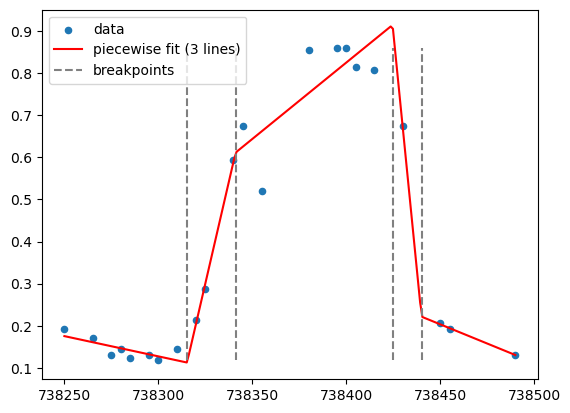

Breakpoints: [738250.         738315.28351793 738341.13413936 738424.66975738
 738440.09434047 738490.        ]
Slopes: [-0.00096005  0.01927133  0.00362421 -0.04487253 -0.00182191]


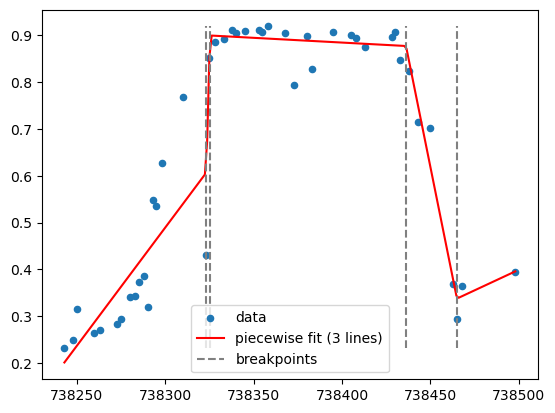

Breakpoints: [738243.         738323.25527925 738325.33752872 738436.18106335
 738465.00000101 738498.        ]
Slopes: [ 0.00505309  0.14066126 -0.00020251 -0.01871953  0.00176035]


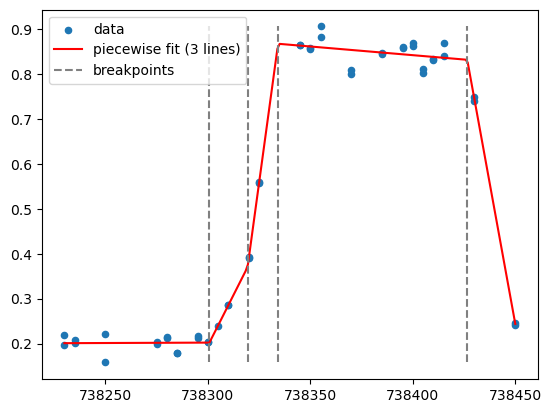

Breakpoints: [738230.         738300.77444641 738319.36900828 738334.25742773
 738426.54719126 738450.        ]
Slopes: [ 1.76693225e-05  9.03598858e-03  3.34131725e-02 -3.86594394e-04
 -2.50845056e-02]


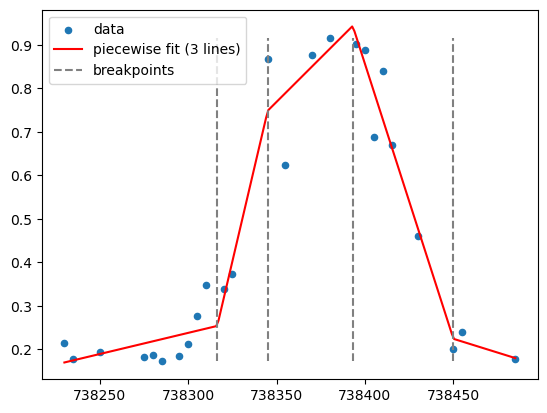

Breakpoints: [738230.         738316.44055794 738344.99999999 738393.06460329
 738450.01062147 738485.        ]
Slopes: [ 0.00097223  0.01732456  0.00405449 -0.01263148 -0.00126611]


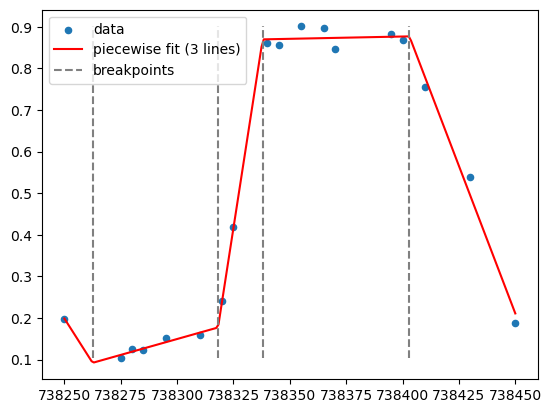

Breakpoints: [738250.         738262.51596891 738318.14442855 738337.94867758
 738403.03647285 738450.        ]
Slopes: [-0.0085143   0.0015278   0.03497984  0.00011056 -0.01418454]


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf  # pip install pwlf

for data in datas:
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    df.set_index('date', inplace=True)

    # Example data roughly bell-shaped
    x = x_data = df.index.map(datetime.toordinal).to_numpy()
    x_data = (x_data - x_data.min()) / 365.25  # normalize
    y = y_data = df['ndvi'].to_numpy()

    # Fit 3-segment piecewise linear model
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    breaks = my_pwlf.fit(5)  # 3 segments → 2 internal breakpoints

    # Predictions
    x_hat = np.linspace(x.min(), x.max(), 200)
    y_hat = my_pwlf.predict(x_hat)

    # Plot
    plt.scatter(x, y, s=20, label='data')
    plt.plot(x_hat, y_hat, 'r-', label='piecewise fit (3 lines)')
    plt.vlines(breaks[1:-1], y.min(), y.max(), color='gray', ls='--', label='breakpoints')
    plt.legend()
    plt.show()

    print("Breakpoints:", breaks)
    print("Slopes:", my_pwlf.slopes)
